In [ ]:
# print('Continue?(1=YES/0=NO)')
# continue_training=bool(int(input()))
continue_training=False

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-beta1
# import logging
# logging.getLogger('tensorflow').disabled = True
import tensorflow as tf
!pip install -q imageio
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2
import random
import time
import shutil, os
from collections import deque
from tensorflow.keras import layers, initializers

from IPython import display
from tqdm import tqdm

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.colab import drive
drive.mount('/gdrive')
path = "/gdrive/My Drive/GAN/"
folder = "Amy_research/DCGAN"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# size = (64, 64, 3)
# imgs = []
# files = os.listdir(path+"pokemon/")
# random.shuffle(files)
# file_range = 10 if len(files)-1 > 4000 else len(files)-1
# for i in tqdm(range(0, file_range)):
#     img = mpimg.imread(path+"pokemon/"+str(files[i]))
#     img = cv2.resize(img, (size[0], size[1]), interpolation = cv2.INTER_AREA)
# #     img = img / 255.0
#     imgs.append(img)
    

# train_images = np.array(imgs).astype('float32')
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 255
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:1000]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_encoder_model():
    model = tf.keras.Sequential()
#     model.add(layers.GaussianNoise(.25))
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(200))

    return model

encoder = make_encoder_model()
mean, logvar = tf.split(encoder(np.array([train_images[0]])), num_or_size_splits=2, axis=1)
eps = tf.random.normal(shape=mean.shape)
z = eps * tf.exp(logvar * .5) + mean

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 64)))
    assert model.output_shape == (None, 7, 7, 64) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#     model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 64, 64, 64)
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, 1, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 1)

#     model.add(layers.Activation('sigmoid'))

    return model

generator = make_generator_model()



In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
#     model.add(layers.GaussianNoise(.25))
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

In [ ]:
cross_entropy_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def regulerizer_loss(z, mean, logvar, generated_images, images):
    logpx_z = cross_entropy(generated_images, images)
    logpz = tf.reduce_mean(log_normal_pdf(z, 0., 0.))
    logqz_x = tf.reduce_mean(log_normal_pdf(z, mean, logvar))
    return -(logpx_z + logpz - logqz_x)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy_logits(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_logits(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss = cross_entropy_logits(tf.ones_like(fake_output), fake_output)
    return loss


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 49


    
seed = tf.Variable(tf.random.normal([num_examples_to_generate, noise_dim]))

checkpoint_dir = path + folder +'_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(seed=seed,
                                 step=tf.Variable(0),
                                 generator=generator,
                                 discriminator=discriminator)



if continue_training:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print(checkpoint.step)
    print('Loaded!')
else:
    try:
        os.mkdir(path+folder+'_imgs')
    except: pass
    try:
        os.mkdir(path+folder+'_checkpoints')
    except: pass
    try:
        os.mkdir(path+folder+'_graphs')
    except: pass
    print(checkpoint.step)
    print('New!')

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
New!


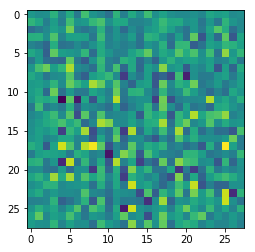

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(z, training=False)
# print(generated_image)

plt.imshow((layers.Reshape((28, 28))(generated_image))[0, :, :])
plt.show()

In [ ]:
EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 49


seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gaus_noise = layers.GaussianNoise(.5)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = Gaus_noise(images)
        
        
        mean, logvar = tf.split(encoder(images, training=True), num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        z = eps * tf.exp(logvar * .5) + mean
        generated_images = layers.Activation('sigmoid')(generator(z, training=True))
        generated_images_with_gaus = Gaus_noise(generated_images)

        real_output = discriminator(images_with_gaus, training=True)
        fake_output = discriminator(generated_images_with_gaus, training=True)

        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        gen_loss += (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables+encoder.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables+encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
#     input()
    
    return gen_loss, disc_loss
    
    
def train(dataset, epochs, start):
    
    discriminate_loss_list = deque(maxlen=50)
    generate_loss_list = deque(maxlen=50)
    
    for epoch in range(start, epochs):
        start = time.time()
        gen_epoch_loss = []
        disc_epoch_loss = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_epoch_loss.append(gen_loss)
            disc_epoch_loss.append(disc_loss)

            
        discriminate_loss_list.append(tf.reduce_mean(disc_epoch_loss))
        generate_loss_list.append(tf.reduce_mean(gen_epoch_loss))

        # Save the model every 15 epochs
        if (epoch) % 20 == 0:
            checkpoint.step.assign(epoch)
            checkpoint.save(file_prefix = checkpoint_prefix)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            plot_graph_disc_and_gan(discriminate_loss_list, generate_loss_list)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = layers.Activation('sigmoid')(model(test_input, training=False))

    fig = plt.figure(figsize=(7,7))

    for i in range(predictions.shape[0]):
        plt.subplot(7, 7, i+1)
        plt.imshow((layers.Reshape((28, 28))(predictions))[i, :, :], cmap='Greys')
        plt.axis('off')

    plt.savefig(path+folder+'_imgs/_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def plot_graph_disc_and_gan(discriminate_loss_list, generate_loss_list):
    plt.figure(2)
    plt.clf()
    plt.plot(generate_loss_list, c='g')
    plt.plot(discriminate_loss_list, c='r')
    plt.savefig(path+folder+'_graphs/graph.png')
    plt.show()

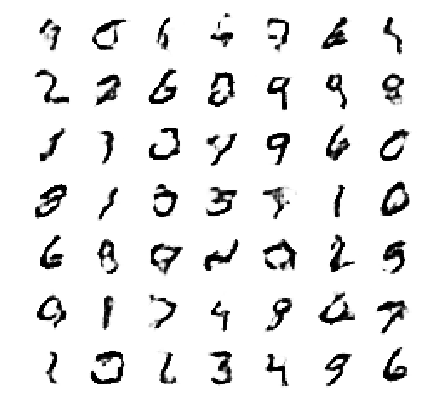

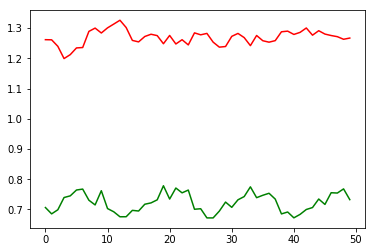

Time for epoch 1461 is 3.7628095149993896 sec
Time for epoch 1462 is 0.21035456657409668 sec
Time for epoch 1463 is 0.19991326332092285 sec
Time for epoch 1464 is 0.20584893226623535 sec
Time for epoch 1465 is 0.2088007926940918 sec
Time for epoch 1466 is 0.20229625701904297 sec
Time for epoch 1467 is 0.20387649536132812 sec
Time for epoch 1468 is 0.20891523361206055 sec
Time for epoch 1469 is 0.20195627212524414 sec
Time for epoch 1470 is 0.20656371116638184 sec
Time for epoch 1471 is 0.20899152755737305 sec
Time for epoch 1472 is 0.20702791213989258 sec
Time for epoch 1473 is 0.20344042778015137 sec
Time for epoch 1474 is 0.2118666172027588 sec
Time for epoch 1475 is 0.20260262489318848 sec
Time for epoch 1476 is 0.2059938907623291 sec
Time for epoch 1477 is 0.20595192909240723 sec
Time for epoch 1478 is 0.20050978660583496 sec


KeyboardInterrupt: ignored

In [ ]:
%%time
train(train_dataset, EPOCHS, checkpoint.step.numpy())